In [1]:
!pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/124.9 MB 656.4 kB/s eta 0:03:11
   ---------------------------------------- 0.1/124.9 MB 655.4 kB/s eta 0:03:11
   ---------------------------------------- 0.2/124.9 MB 952.6 kB/s eta 0:02:11
   ---------------------------------------- 0.5/124.9 MB 2.2 MB/s eta 0:00:58
   ---------------------------------------- 0.8/124.9 MB 3.3 MB/s eta 0:00:38
   ---------------------------------------- 1.4/124.9 MB 4.5 MB/s eta 0:00:28
   ---------------------------------------- 1.5/124.9 MB 4.2 MB/s eta 0:00:30
    --------------------------------------- 2.1/124.9 MB 5.2 MB/s eta 0:00:24
    --------------------------------------- 3.0/124.9 MB 6.6 MB/s eta 0:00:19
   - -------------------------------------- 3.2/124.9 MB 6.6 MB/s eta 0:00:19
   - -------------------------------------- 4.0/124.9 MB 7.3 MB/s eta 0:


[notice] A new release of pip is available: 23.3.2 -> 24.1.1
[notice] To update, run: C:\Users\thien\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import os
# Set environment variable
if "ACCEPT_TC" not in os.environ:
    os.environ["ACCEPT_TC"] = "tôi đồng ý"
from datetime import datetime
import pandas as pd
import numpy as np
import xgboost as xgb
from vnstock3 import Vnstock
import pandas_ta as ta
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import F  # Assuming 'F' is a module you've created
import matplotlib.pyplot as plt

In [3]:
# Get current date
now = datetime.now()
current_date = now.strftime("%Y-%m-%d")

# Fetch VN30 and VNI stock data
vn30 = Vnstock().stock(symbol='VN30', source='VCI')
df_vn30 = vn30.quote.history(start='2020-08-01', end=current_date, to_df=True)

vni = Vnstock().stock(symbol='VNINDEX', source='VCI')
df_vni = vni.quote.history(start='2020-08-01', end=current_date, to_df=True)

2024-07-06 14:46:09,483 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS


2024-07-06 14:46:12,911 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS


In [4]:
# Function to process data
def process_data(data):
    data['time'] = pd.to_datetime(data['time'])
    data.sort_values(by='time', ascending=True, inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    data['close'] = pd.to_numeric(data['close'], errors='coerce')
    data['sma5'] = ta.sma(data['close'], length=5)
    data['sma10'] = ta.sma(data['close'], length=10)
    data['ema5'] = ta.ema(data['close'], length=5)
    data['ema10'] = ta.ema(data['close'], length=10)
    data['rsi'] = ta.rsi(data['close'], length=14)
    data.ta.macd(close='close', fast=12, slow=26, signal=9, append=True)

    data.dropna(inplace=True)
    data.reset_index(drop=True, inplace=True)
    return data

# Process the VN30 and VNI data
data_VN30 = process_data(df_vn30)
data_VNI = process_data(df_vni)

# Function to prepare data for XGBoost model
def prepare_data(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Function to train XGBoost model
def model_XGBoost(data, time_steps=60, epochs=50):
    data_features = data[['close', 'sma5', 'sma10', 'ema5', 'ema10', 'rsi', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9']].values
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_features)
    
    X, y = prepare_data(data_scaled, time_steps)
    X = X.reshape(X.shape[0], -1)
    
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=epochs)
    model.fit(X, y)
    return model, scaler, time_steps

# Function to get prediction from XGBoost model
def output_XGBoost(model, scaler, data, time_steps=60):
    data_features = data[['close', 'sma5', 'sma10', 'ema5', 'ema10', 'rsi', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9']].values
    data_scaled = scaler.transform(data_features)
    
    X = np.array([data_scaled[-time_steps:]])
    X = X.reshape(X.shape[0], -1)
    
    predicted_price = model.predict(X)
    predicted_price = scaler.inverse_transform(np.concatenate([predicted_price.reshape(-1, 1), np.zeros((predicted_price.shape[0], data_features.shape[1]-1))], axis=1))[:, 0]
    
    return predicted_price[0]

# Backtesting function
def test(data, k):
    data_output = data[['time', 'close']].copy()
    data_output['position'] = 0

    # Initialize model
    model_xgb, scaler_xgb, time_steps_xgb = model_XGBoost(data, time_steps=k)
    
    for i in range(k, len(data)):
        historical_data = data.iloc[i-k:i]
        
        xgb_pred = output_XGBoost(model_xgb, scaler_xgb, historical_data, time_steps_xgb)
        
        predictions = xgb_pred - data.iloc[i-1]['close']
        
        data_output.loc[i, 'position'] = 1 if predictions > 2 else (-1 if predictions < -2 else 0)
    
    data_output.dropna(inplace=True)
    return data_output

# Plotting function for PNL with annotation
def plot_pnl_with_annotation(data, symbol):
    backtesting = F.BacktestInformation(data['time'], data['position'], data['close'])
    pnl_data = backtesting.Plot_PNL(plot=False)
    
    # Plot PNL
    plt.figure(figsize=(15, 6))
    pnl_data['total_gain'].plot(label='Total Gain')
    pnl_data['total_gain_after_fee'].plot(label='Total Gain After Fee')

    plt.title(f'PNL for {symbol}')
    plt.xlabel('Time')
    plt.ylabel('PNL')
    plt.legend()
    plt.grid(True)
    plt.annotate(f'Stock: {symbol}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12,
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))
    plt.show()


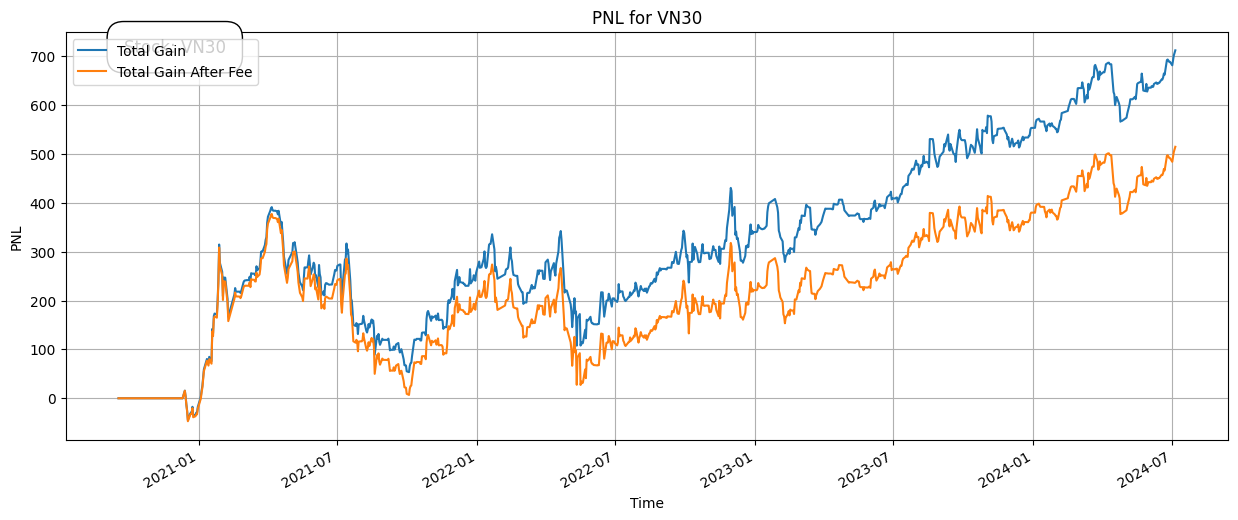

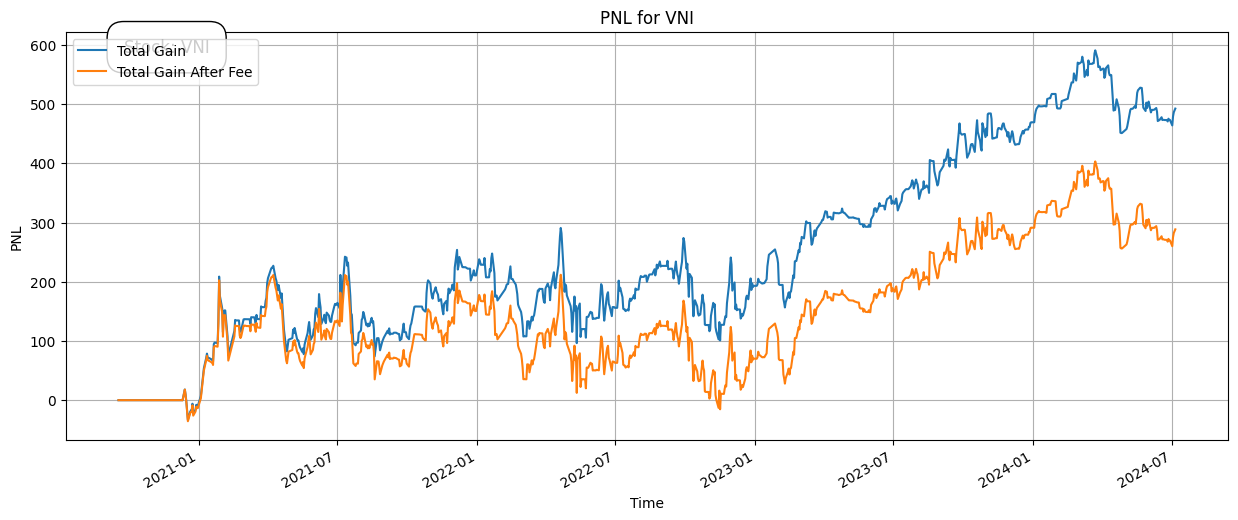

Backtesting Results for VN30
Margin: 6.7712436592368475
MDD: (580.0583966244698, 0.37448490695275494)

   Total trading quantity: 401
         Profit per trade: 1.7761097256857916
             Total Profit: 712.2
         Profit after fee: 514.7
 Trading quantity per day: 0.4229957805907173
 Profit per day after fee: 0.5429324894514769
                   Return: 0.08744463567000398
          Profit per year: 135.44736842105266
                  HitRate: 0.456359102244389
          HitRate per day: 0.426610348468849


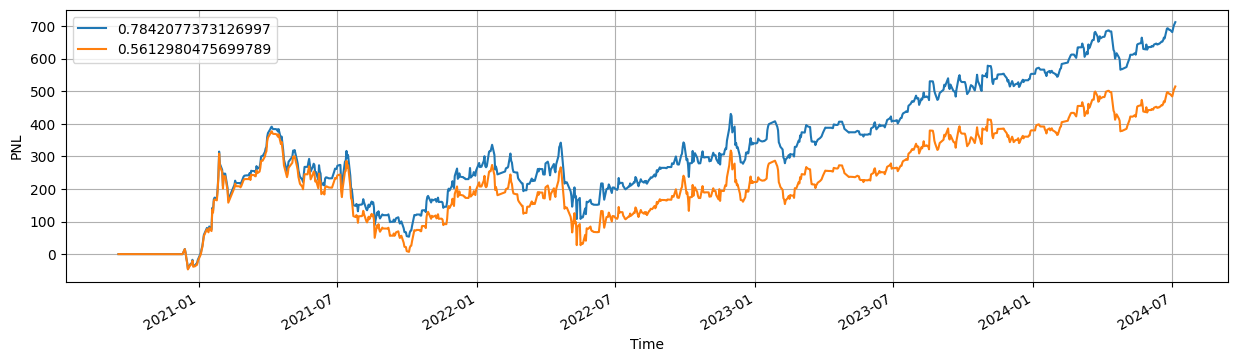

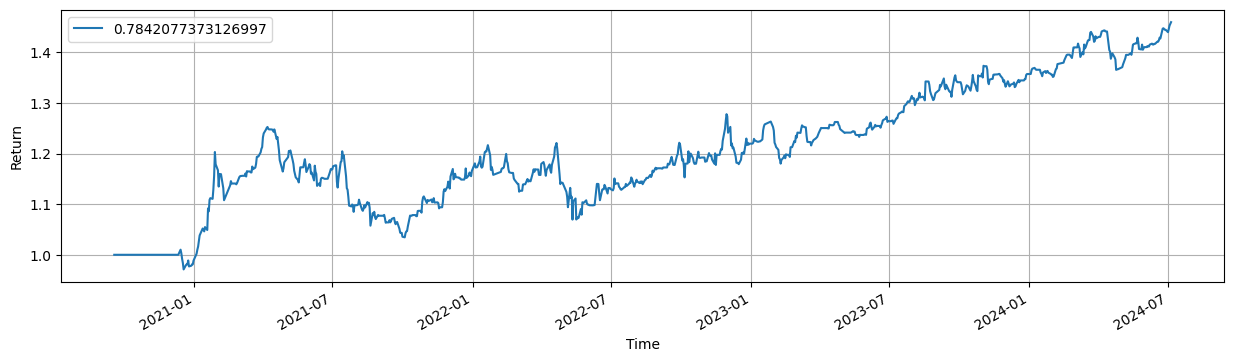

Backtesting Results for VNI
Margin: 4.585092875283483
MDD: (635.5840084388217, 0.4214776016013513)

   Total trading quantity: 412
         Profit per trade: 1.195218446601931
             Total Profit: 492.4
         Profit after fee: 288.5
 Trading quantity per day: 0.4345991561181435
 Profit per day after fee: 0.3043248945147679
                   Return: 0.05034585947624251
          Profit per year: 75.92105263157895
                  HitRate: 0.42961165048543687
          HitRate per day: 0.4118268215417107


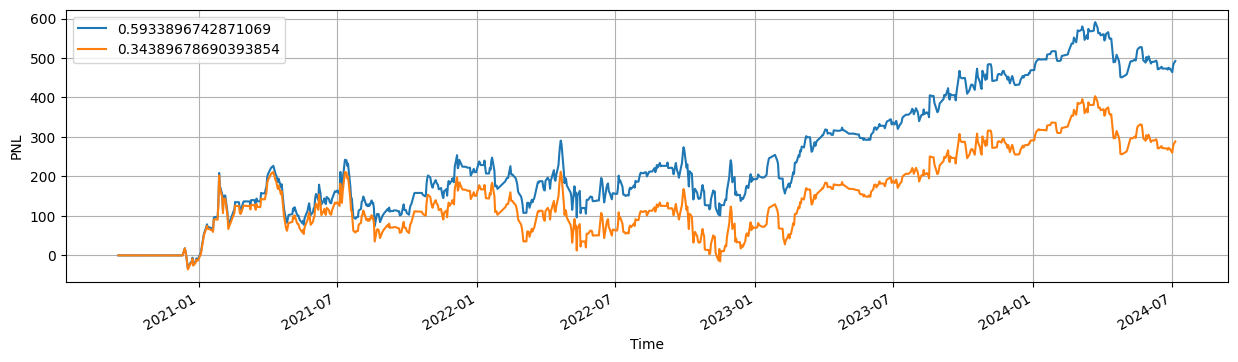

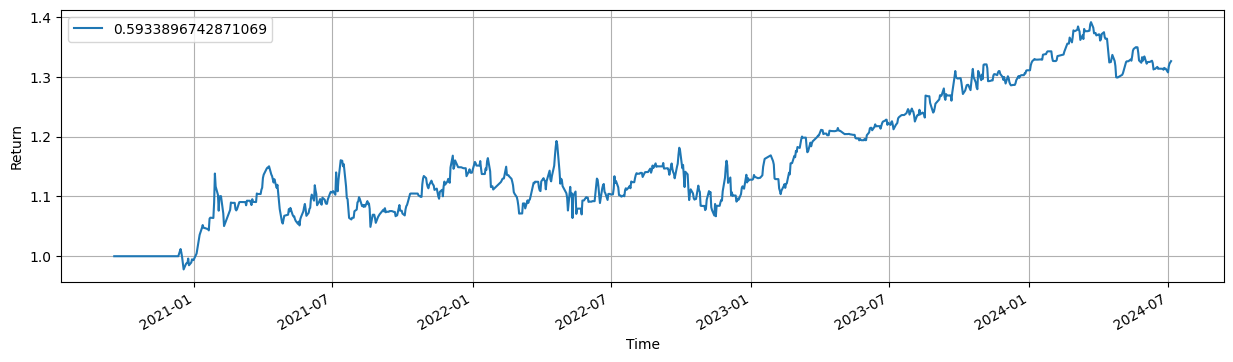

,total_gain,fee,total_gain_after_fee,Position,Close,Return
Datetime,,,,,,
2020-09-18,0.00,0.000000,0.000000,0,900.95,1.000000
2020-09-21,0.00,0.000000,0.000000,0,907.94,1.000000
2020-09-22,0.00,0.000000,0.000000,0,906.19,1.000000
2020-09-23,0.00,0.000000,0.000000,0,912.50,1.000000
2020-09-24,0.00,0.000000,0.000000,0,908.58,1.000000
...,...,...,...,...,...,...
2024-07-01,463.95,203.944262,260.005738,1,1254.56,1.307661
2024-07-02,479.18,203.944262,275.235738,1,1269.79,1.317761
2024-07-03,486.24,203.944262,282.295738,1,1276.85,1.322442


In [5]:
# Run the backtesting for VN30 and VNI
data_VNI_position = test(data_VNI, 60)
data_VN30_position = test(data_VN30, 60)

plot_pnl_with_annotation(data_VN30_position, 'VN30')
plot_pnl_with_annotation(data_VNI_position, 'VNI')

# Print backtesting results
backtesting_VN30 = F.BacktestInformation(data_VN30_position['time'], data_VN30_position['position'], data_VN30_position['close'])
backtesting_VNI = F.BacktestInformation(data_VNI_position['time'], data_VNI_position['position'], data_VNI_position['close'])

print("Backtesting Results for VN30")
backtesting_VN30.Plot_PNL()

print("Backtesting Results for VNI")
backtesting_VNI.Plot_PNL()